First, read in the data and check out the columns:

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
fpp_all = pd.read_csv('fpp_final_table.csv', index_col=0)
fpp_all.count()

/u/tdm/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


koi.1                    7470
rprs                     7202
secthresh                7202
maxrad                   7202
pr_heb                   7026
pr_heb_Px2               7026
pr_eb                    7026
pr_eb_Px2                7026
pr_beb                   7026
pr_beb_Px2               7026
L_tot                    7049
fp                       7049
FPP                      7026
kepid                    7470
period                   7470
rp                       7128
disposition              7470
prob_ontarget            6790
pos_prob_score           7470
not_transitlike          7470
significant_secondary    7470
centroid_offset          7470
ephem_match              7470
MES                      7470
exception                 421
has_ttv                  7268
n_cands                  7470
dtype: int64

Now, we want to split up this whole population into distinct subsets, based on sequential categorizations, in the following order:

* Archive disposition (based on the cumulative table). CONFIRMED and FALSE POSITIVE are their own category; CANDIDATE gets further subdivided.  
* Whether the `vespa` calculation worked or not.
* Whether positional probability calculation is reliable (based on `prob_score_thresh`).  Unreliable goes into "uncertain" category; 
* Reliable positional probs gets further divided based on prob > 0.99 or not.
* Positional prob > 0.99 gets further divided by FPP.  The "newly validated" subset is the subset of these with FPP < 0.01

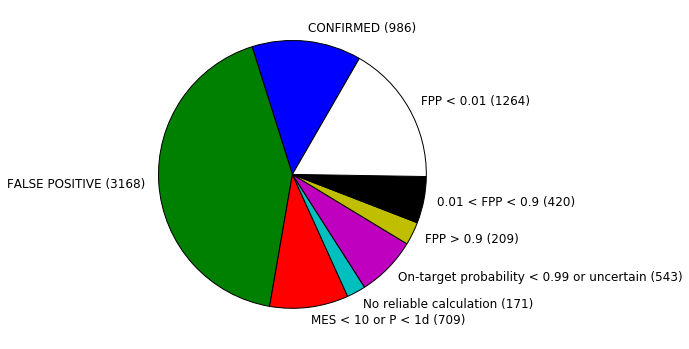

In [2]:
prob_score_thresh = 0.3

confirmed = fpp_all['disposition'] == 'CONFIRMED'
known_fp = fpp_all['disposition'] == 'FALSE POSITIVE'
candidate = fpp_all['disposition'] == 'CANDIDATE'
low_fpp = fpp_all['FPP'] < 0.01
hi_fpp = fpp_all['FPP'] > 0.9
med_fpp = (fpp_all['FPP'] >= 0.01) & (fpp_all['FPP'] <=0.9)
snr_low = fpp_all['MES'] < 10
snr_good = fpp_all['MES'] >= 10
on_target = (fpp_all['prob_ontarget'] >= 0.99) & (fpp_all['pos_prob_score'] >= prob_score_thresh)
off_target = (fpp_all['prob_ontarget'] < 0.99) & (fpp_all['pos_prob_score'] >= prob_score_thresh)
target_ambiguous = ((fpp_all['pos_prob_score'] < prob_score_thresh) | 
                    np.isnan(fpp_all['pos_prob_score']) | 
                    np.isnan(fpp_all['prob_ontarget']))
not_crazy = fpp_all['L_tot'] > 1e-3
crazy = fpp_all['L_tot'] <= 1e-3
short_period = fpp_all['period'] < 1.
period_ok = fpp_all['period'] >= 1.

fpp_calculated = np.isfinite(fpp_all['FPP']) 
d = fpp_all[fpp_calculated]

#reliable = (confirmed | candidate) & on_target & not_crazy
#print(sum(reliable))
#print(sum(reliable & low_fpp))
#print(sum(candidate & on_target & not_crazy & low_fpp))
#print(sum(confirmed))
#print(sum(candidate & high_fpp))
#print(sum(confirmed & high_fpp))

newfp = (candidate & fpp_calculated & not_crazy & on_target & hi_fpp & snr_good & period_ok)
newmed = (candidate & fpp_calculated & not_crazy & on_target & med_fpp & snr_good & period_ok)
newval = (candidate & fpp_calculated & not_crazy & on_target & low_fpp & snr_good & period_ok)

categories = [ confirmed, known_fp, (candidate & (snr_low | short_period)),
              ((candidate & ~fpp_calculated & snr_good & period_ok) | 
               (candidate & fpp_calculated & crazy & snr_good & period_ok)),
              ((candidate & fpp_calculated & not_crazy & target_ambiguous & snr_good & period_ok) | 
               (candidate & fpp_calculated & not_crazy & off_target & snr_good & period_ok)),
              newfp, newmed, newval]

labels = ['CONFIRMED ({})'.format(categories[0].sum()),
          'FALSE POSITIVE ({})'.format(categories[1].sum()),
          'MES < 10 or P < 1d ({})'.format(categories[2].sum()),
          'No reliable calculation ({})'.format(categories[3].sum()),
          'On-target probability < 0.99 or uncertain ({})'.format(categories[4].sum()),
          #'On-target probability < 0.99 ({})'.format(categories[5].sum()), 
          'FPP > 0.9 ({})'.format(categories[5].sum()), 
          '0.01 < FPP < 0.9 ({})'.format(categories[6].sum()), 
          'FPP < 0.01 ({})'.format(categories[7].sum())]

needmore = categories[3] | categories[4] | categories[5] 

sums = np.array([c.sum() for c in categories])
fracs = sums / float(sums.sum()) * 100

fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.pie(fracs, labels=labels, startangle=60);

Let's take a look at just the validated subset, and write that to a file:

In [3]:
fpp_all[newval].count()
fpp_all[newval].to_csv('newly_validated.csv')

In [4]:
fpp_all[newval].head()

,koi.1,rprs,secthresh,maxrad,pr_heb,pr_heb_Px2,pr_eb,pr_eb_Px2,pr_beb,pr_beb_Px2,...,prob_ontarget,pos_prob_score,not_transitlike,significant_secondary,centroid_offset,ephem_match,MES,exception,has_ttv,n_cands
koi,,,,,,,,,,,,,,,,,,,,,
K00049.01,K00049.01,0.026,52,0.50,7.620000e-24,7.260000e-15,2.540000e-45,4.540000e-25,1.810000e-07,1.390000e-12,...,1,1,False,False,False,False,93.30270,NaN,False,1
K00089.01,K00089.01,0.017,34,0.75,4.140000e-07,4.640000e-40,1.960000e-08,1.090000e-58,1.350000e-27,3.840000e-18,...,1,1,False,False,False,False,71.36428,NaN,True,2
K00105.01,K00105.01,0.031,27,0.50,1.070000e-03,6.420000e-08,5.950000e-03,1.630000e-10,3.510000e-06,5.560000e-13,...,1,1,False,False,False,False,197.65842,NaN,False,1
K00107.01,K00107.01,0.019,21,0.50,1.670000e-16,2.270000e-11,5.610000e-10,1.100000e-18,2.060000e-23,4.010000e-38,...,1,1,False,False,False,False,113.51270,NaN,False,1
K00110.01,K00110.01,0.021,19,0.50,8.950000e-06,2.000000e-11,8.590000e-05,7.280000e-05,2.680000e-07,1.260000e-15,...,1,1,False,False,False,False,148.50294,NaN,False,1
